In [14]:
import os
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryJaccardIndex

import albumentations as A
from albumentations.pytorch import ToTensorV2

import clearml
from clearml import Task
from kaggle_secrets import UserSecretsClient

In [15]:
# Настройка ClearML
user_secrets = UserSecretsClient()
access_key = user_secrets.get_secret("CLEARML_ACCESS_KEY")
secret_key = user_secrets.get_secret("CLEARML_SECRET_KEY")

os.environ['CLEARML_API_ACCESS_KEY'] = access_key
os.environ['CLEARML_API_SECRET_KEY'] = secret_key

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
base_dir = '/Users/maks2/OneDrive/projects/retina-segmentation/Data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_image_path = os.path.join(train_dir, 'image')
train_mask_path = os.path.join(train_dir, 'mask')

test_image_path = os.path.join(test_dir, 'image')
test_mask_path = os.path.join(test_dir, 'mask')

In [18]:
paired_train_images = []
paired_train_masks = []

for img_path in sorted(glob(os.path.join(train_image_path, '*.png'))):
    basename = os.path.basename(img_path)
    expected_mask_path = os.path.join(train_mask_path, basename)

    
    if os.path.exists(expected_mask_path):
        paired_train_images.append(img_path)
        paired_train_masks.append(expected_mask_path)

print(f"Найдено {len(paired_train_images)} пар в тренировочной выборке")

Найдено 80 пар в тренировочной выборке


In [19]:
def show_img_mask(img_path: str, mask_path: str, number: int):
    """Визуализирует изображение с маской по заданному порядковому номеру"""
    img_show = cv2.imread(img_path[number], cv2.IMREAD_GRAYSCALE)
    mask_show = cv2.imread(mask_path[number], cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img_show)
    plt.title('Img')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_show)
    plt.title('Mask')

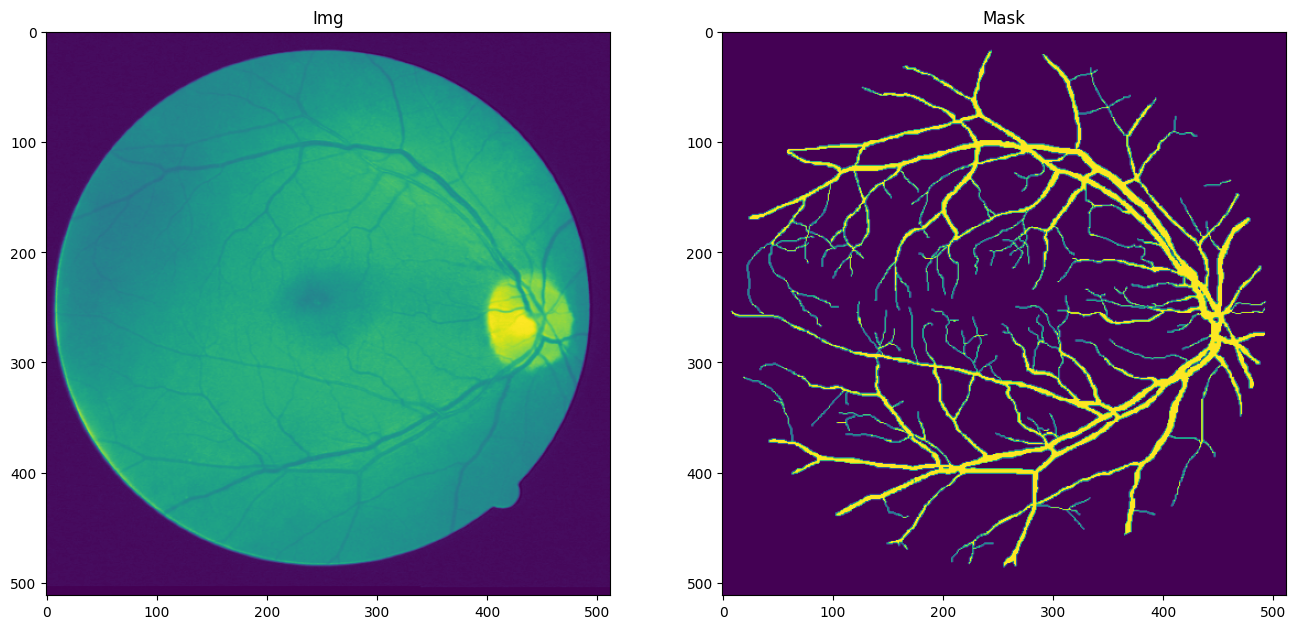

In [20]:
show_img_mask(paired_train_images, paired_train_masks, 19)

In [21]:
def compute_stats(img_paths):
    """Находит mean и std для нормализации"""
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    count = 0
    
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        
        pixel_sum += img.mean(axis=(0, 1))
        pixel_sq_sum += (img**2).mean(axis=(0, 1))
        count += 1
    
    # Вычисляем mean и std
    mean = pixel_sum / count
    std = np.sqrt((pixel_sq_sum / count) - mean**2)
    
    return mean, std

mean, std = compute_stats(paired_train_images)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.50390585 0.27421722 0.16436354]
Std: [0.34486165 0.18855133 0.10701356]


In [26]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

compute_mean = [0.504, 0.275, 0.164]
compute_std = [0.345, 0.189, 0.107]

train_transforms = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=compute_mean, std=compute_std),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Normalize(mean=compute_mean, std=compute_std),
    ToTensorV2(),
])

In [ ]:
class RetinaDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transforms=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask > 0] = 1.0

        augmented = self.transforms(image=image, mask=mask)
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']
        
        mask_tensor = mask_tensor.unsqueeze(0)
        mask_tensor = mask_tensor.float()
        
        return image_tensor, mask_tensor

In [ ]:
num_workers = 2
batch_size = 16

train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    paired_train_images,
    paired_train_masks,
    test_size=0.2,
    random_state=42 
)
train_data = RetinaDataset(train_img_paths, train_mask_paths, transforms=train_transforms)
val_data = RetinaDataset(val_img_paths, val_mask_paths, transforms=val_transforms)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

In [ ]:
# Добавим модификации к оригинальной архитектуре. 
# К примеру - padding = 1(в оригинале от паддинга отказались за счет *более правдивой сегментации*)
# Также добавим батчнорм

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv_block(x)

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels)
        )

        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        conv_path = self.conv_block(x)
        residual = self.shortcut(x)

        conv_path += residual

        conv_path = self.activation(conv_path)

        return conv_path
        

In [ ]:
class RRCBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t=2):
        super(RRCBlock, self).__init__()
    
        self.t = t
    
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
            
        self.main_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        recurrent = residual
        
        for i in range(self.t):
            recurrent = self.main_conv(residual + recurrent)
            recurrent = self.bn(recurrent)
            recurrent = self.relu(recurrent)

        return recurrent

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels_x, in_channels_g, out_channels):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(in_channels_g, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels_x, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels)
        )
        
        self.relu = nn.ReLU(inplace=True)
        
        self.psi = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        psi = self.relu(g1 + x1)
        
        psi = self.psi(psi)
        
        return x * psi


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Encoder
        self.down_conv1 = RRCBlock(in_channels, 64)
        self.down_conv2 = RRCBlock(64, 128)
        self.down_conv3 = RRCBlock(128, 256)
        self.down_conv4 = RRCBlock(256, 512)

        # bottleneck
        self.bottleneck = RRCBlock(512, 1024)

        # Decoder        
        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_double_conv1 = RRCBlock(1024, 512)
        
        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_double_conv2 = RRCBlock(512, 256)
        
        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_double_conv3 = RRCBlock(256, 128)
        
        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_double_conv4 = RRCBlock(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.down_conv1(x)
        p1 = self.pool(e1)

        e2 = self.down_conv2(p1)
        p2 = self.pool(e2)

        e3 = self.down_conv3(p2)
        p3 = self.pool(e3)

        e4 = self.down_conv4(p3)
        p4 = self.pool(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d4 = self.up_conv1(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.up_double_conv1(d4)

        d3 = self.up_conv2(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.up_double_conv2(d3)

        d2 = self.up_conv3(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.up_double_conv3(d2)

        d1 = self.up_conv4(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.up_double_conv4(d1)

        return self.out_conv(d1)
        

In [34]:
class R2AttU_Net(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(R2AttU_Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Encoder
        self.down_conv1 = ResidualBlock(in_channels, 64)
        self.down_conv2 = ResidualBlock(64, 128)
        self.down_conv3 = ResidualBlock(128, 256)
        self.down_conv4 = ResidualBlock(256, 512)

        # Bottleneck
        self.bottleneck = ResidualBlock(512, 1024)

        # Decoder        
        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.Att1 = AttentionBlock(512, 512, 256)
        self.up_double_conv1 = ResidualBlock(1024, 512)
        
        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.Att2 = AttentionBlock(256, 256, 128)
        self.up_double_conv2 = ResidualBlock(512, 256)
        
        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.Att3 = AttentionBlock(128, 128, 64)
        self.up_double_conv3 = ResidualBlock(256, 128)
        
        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.Att4 = AttentionBlock(64, 64, 32)
        self.up_double_conv4 = ResidualBlock(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down_conv1(x)
        p1 = self.pool(x1)

        x2 = self.down_conv2(p1)
        p2 = self.pool(x2)

        x3 = self.down_conv3(p2)
        p3 = self.pool(x3)

        x4 = self.down_conv4(p3)
        p4 = self.pool(x4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d4 = self.up_conv1(b)
        x4_att = self.Att1(x=x4, g=d4)
        d4 = torch.cat([d4, x4_att], dim=1)
        d4 = self.up_double_conv1(d4)

        d3 = self.up_conv2(d4)
        x3_att = self.Att2(x=x3, g=d3)
        d3 = torch.cat([d3, x3_att], dim=1)
        d3 = self.up_double_conv2(d3)

        d2 = self.up_conv3(d3)
        x2_att = self.Att3(x=x2, g=d2)
        d2 = torch.cat([d2, x2_att], dim=1)
        d2 = self.up_double_conv3(d2)

        d1 = self.up_conv4(d2)
        x1_att = self.Att4(x=x1, g=d1)
        d1 = torch.cat([d1, x1_att], dim=1)
        d1 = self.up_double_conv4(d1)

        return self.out_conv(d1)

In [ ]:
# 1. Определяем все параметры
hyperparams = {
    'architecture': 'ResAttU_Net',
    'learning_rate': 1e-3,
    'weight_decay': 1e-6,
    'epochs': 50,
    'batch_size': 16,
    'optimizer': 'Adam',
    'loss_function': 'DiceLoss',
    'augmentations': True
}
# 2. Инициализируем задачу
task = Task.init(
    project_name="Retina Segmentation",
    task_name="ResAttU_Net with many augment"
)

# 3. Подключаем параметры
task.connect(hyperparams)

# 4. Добавляем теги
task.add_tags(["ResAttU_Net", "augmentations"])

# 5. Добавляем описание
task.set_comment("ResAttU_Net и много аугментаций")

# 6. Получаем логгер
logger = task.get_logger()


ClearML Task: created new task id=cad9ecd474eb435c8cae77d09acb617c
2025-08-04 16:07:02,459 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2025-08-04 16:07:02,486 - clearml.Task - INFO - Storing jupyter notebook directly as code


2025-08-04 16:07:04.441186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754323624.648954      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754323624.710126      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ClearML results page: https://app.clear.ml/projects/056e89dcb5f84fa085b761c8dec3b8de/experiments/cad9ecd474eb435c8cae77d09acb617c/output/log


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, labels):
        """Вычисляет Dice Loss"""
        preds = torch.sigmoid(logits)
        
        #сглаживаем предсказания и маски, чтобы избежать деления на ноль
        preds_flat = preds.contiguous().view(preds.shape[0], -1)
        labels_flat = labels.contiguous().view(labels.shape[0], -1)
        
        intersection = (preds_flat * labels_flat).sum(1)
        union = preds_flat.sum(1) + labels_flat.sum(1)
        
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        
        #усредняем Dice Score по батчу и вычисляем лосс
        dice_loss = 1 - dice_score.mean()
        
        return dice_loss

In [37]:
def fit_epoch(model, criterion, optimizer, metric, train_loader, device):
    """Обучает модель на одной эпохе."""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    epoch_iou = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        epoch_iou += metric(outputs, labels).item()

    epoch_loss = running_loss / total_samples
    epoch_iou /= len(train_loader)
    return epoch_loss, epoch_iou

def val_epoch(model, criterion, metric, val_loader, device):
    """Валидирует модель на одной эпохе"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    epoch_iou = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            epoch_iou += metric(outputs, labels).item()

    epoch_loss = running_loss / total_samples
    epoch_iou /= len(val_loader)
    return epoch_loss, epoch_iou

def train_model(model, criterion, optimizer, metric, train_loader, val_loader, epochs, device, logger):
    """Обучает модель на протяжении нескольких эпох."""
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        tqdm.write(f'--- Эпоха {epoch + 1}/{epochs} ---')

        train_loss, train_iou = fit_epoch(model, criterion, optimizer, metric, train_loader, device)
        val_loss, val_iou = val_epoch(model, criterion, metric, val_loader, device)
        
        logger.report_scalar(title="Loss", series="Train", value=train_loss, iteration=epoch)
        logger.report_scalar(title="IoU", series="Train", value=train_iou, iteration=epoch)
        logger.report_scalar(title="Loss", series="Validation", value=val_loss, iteration=epoch)
        logger.report_scalar(title="IoU", series="Validation", value=val_iou, iteration=epoch)
        
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")

    plot_losses(train_losses, val_losses, train_ious, val_ious)

def plot_losses(train_losses, val_losses, train_iou, val_iou):
    """Визуализирует потери и IoU на графиках."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_iou, label="Train IoU")
    plt.plot(val_iou, label="Val IoU")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.title("Train and Validation IoU")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

--- Эпоха 1/50 ---


Epochs:   2%|▏         | 1/50 [00:05<04:43,  5.78s/it]

Train Loss: 0.7734, Val Loss: 0.8027, Train IoU: 0.1523, Val IoU: 0.1706
--- Эпоха 2/50 ---


Epochs:   4%|▍         | 2/50 [00:11<04:40,  5.84s/it]

Train Loss: 0.7284, Val Loss: 0.7973, Train IoU: 0.1752, Val IoU: 0.1736
--- Эпоха 3/50 ---


Epochs:   6%|▌         | 3/50 [00:17<04:36,  5.89s/it]

Train Loss: 0.7082, Val Loss: 0.7897, Train IoU: 0.1781, Val IoU: 0.1743
--- Эпоха 4/50 ---


Epochs:   8%|▊         | 4/50 [00:23<04:34,  5.97s/it]

Train Loss: 0.6920, Val Loss: 0.7806, Train IoU: 0.1842, Val IoU: 0.1811
--- Эпоха 5/50 ---


Epochs:  10%|█         | 5/50 [00:29<04:32,  6.05s/it]

Train Loss: 0.6748, Val Loss: 0.7728, Train IoU: 0.2052, Val IoU: 0.1923
--- Эпоха 6/50 ---


Epochs:  12%|█▏        | 6/50 [00:36<04:28,  6.11s/it]

Train Loss: 0.6582, Val Loss: 0.7634, Train IoU: 0.2348, Val IoU: 0.1495
--- Эпоха 7/50 ---


Epochs:  14%|█▍        | 7/50 [00:42<04:23,  6.12s/it]

Train Loss: 0.6403, Val Loss: 0.7303, Train IoU: 0.2702, Val IoU: 0.2705
--- Эпоха 8/50 ---


Epochs:  16%|█▌        | 8/50 [00:48<04:16,  6.11s/it]

Train Loss: 0.6236, Val Loss: 0.7006, Train IoU: 0.2959, Val IoU: 0.2976
--- Эпоха 9/50 ---


Epochs:  18%|█▊        | 9/50 [00:54<04:08,  6.07s/it]

Train Loss: 0.6067, Val Loss: 0.6522, Train IoU: 0.3168, Val IoU: 0.3460
--- Эпоха 10/50 ---


Epochs:  20%|██        | 10/50 [01:00<04:00,  6.00s/it]

Train Loss: 0.5915, Val Loss: 0.6171, Train IoU: 0.3345, Val IoU: 0.3619
--- Эпоха 11/50 ---


Epochs:  22%|██▏       | 11/50 [01:06<03:51,  5.95s/it]

Train Loss: 0.5796, Val Loss: 0.5864, Train IoU: 0.3466, Val IoU: 0.3965
--- Эпоха 12/50 ---


Epochs:  24%|██▍       | 12/50 [01:11<03:44,  5.90s/it]

Train Loss: 0.5679, Val Loss: 0.5661, Train IoU: 0.3650, Val IoU: 0.4030
--- Эпоха 13/50 ---


Epochs:  26%|██▌       | 13/50 [01:17<03:37,  5.87s/it]

Train Loss: 0.5594, Val Loss: 0.5569, Train IoU: 0.3772, Val IoU: 0.4019
--- Эпоха 14/50 ---


Epochs:  28%|██▊       | 14/50 [01:23<03:30,  5.85s/it]

Train Loss: 0.5492, Val Loss: 0.5514, Train IoU: 0.3926, Val IoU: 0.4000
--- Эпоха 15/50 ---


Epochs:  30%|███       | 15/50 [01:29<03:24,  5.83s/it]

Train Loss: 0.5404, Val Loss: 0.5311, Train IoU: 0.4087, Val IoU: 0.4205
--- Эпоха 16/50 ---


Epochs:  32%|███▏      | 16/50 [01:34<03:18,  5.82s/it]

Train Loss: 0.5327, Val Loss: 0.5294, Train IoU: 0.4203, Val IoU: 0.4210
--- Эпоха 17/50 ---


Epochs:  34%|███▍      | 17/50 [01:40<03:13,  5.85s/it]

Train Loss: 0.5234, Val Loss: 0.5147, Train IoU: 0.4405, Val IoU: 0.4562
--- Эпоха 18/50 ---


Epochs:  36%|███▌      | 18/50 [01:46<03:07,  5.87s/it]

Train Loss: 0.5144, Val Loss: 0.5070, Train IoU: 0.4518, Val IoU: 0.4627
--- Эпоха 19/50 ---


Epochs:  38%|███▊      | 19/50 [01:52<03:02,  5.90s/it]

Train Loss: 0.5077, Val Loss: 0.5026, Train IoU: 0.4589, Val IoU: 0.4643
--- Эпоха 20/50 ---


Epochs:  40%|████      | 20/50 [01:58<02:57,  5.92s/it]

Train Loss: 0.5021, Val Loss: 0.5026, Train IoU: 0.4720, Val IoU: 0.4725
--- Эпоха 21/50 ---


Epochs:  42%|████▏     | 21/50 [02:04<02:51,  5.93s/it]

Train Loss: 0.4948, Val Loss: 0.4923, Train IoU: 0.4802, Val IoU: 0.4790
--- Эпоха 22/50 ---


Epochs:  44%|████▍     | 22/50 [02:10<02:46,  5.94s/it]

Train Loss: 0.4865, Val Loss: 0.4847, Train IoU: 0.4912, Val IoU: 0.5042
--- Эпоха 23/50 ---


Epochs:  46%|████▌     | 23/50 [02:16<02:40,  5.93s/it]

Train Loss: 0.4798, Val Loss: 0.4917, Train IoU: 0.5035, Val IoU: 0.4719
--- Эпоха 24/50 ---


Epochs:  48%|████▊     | 24/50 [02:22<02:33,  5.92s/it]

Train Loss: 0.4750, Val Loss: 0.4699, Train IoU: 0.5051, Val IoU: 0.5076
--- Эпоха 25/50 ---


Epochs:  50%|█████     | 25/50 [02:28<02:27,  5.91s/it]

Train Loss: 0.4683, Val Loss: 0.4692, Train IoU: 0.5160, Val IoU: 0.5095
--- Эпоха 26/50 ---


Epochs:  52%|█████▏    | 26/50 [02:34<02:21,  5.90s/it]

Train Loss: 0.4612, Val Loss: 0.4626, Train IoU: 0.5211, Val IoU: 0.5119
--- Эпоха 27/50 ---


Epochs:  54%|█████▍    | 27/50 [02:40<02:15,  5.89s/it]

Train Loss: 0.4551, Val Loss: 0.4496, Train IoU: 0.5298, Val IoU: 0.5381
--- Эпоха 28/50 ---


Epochs:  56%|█████▌    | 28/50 [02:45<02:09,  5.88s/it]

Train Loss: 0.4493, Val Loss: 0.4487, Train IoU: 0.5340, Val IoU: 0.5287
--- Эпоха 29/50 ---


Epochs:  58%|█████▊    | 29/50 [02:51<02:03,  5.88s/it]

Train Loss: 0.4436, Val Loss: 0.4418, Train IoU: 0.5410, Val IoU: 0.5320
--- Эпоха 30/50 ---


Epochs:  60%|██████    | 30/50 [02:57<01:57,  5.86s/it]

Train Loss: 0.4394, Val Loss: 0.4383, Train IoU: 0.5445, Val IoU: 0.5338
--- Эпоха 31/50 ---


Epochs:  62%|██████▏   | 31/50 [03:03<01:51,  5.87s/it]

Train Loss: 0.4327, Val Loss: 0.4266, Train IoU: 0.5506, Val IoU: 0.5566
--- Эпоха 32/50 ---


Epochs:  64%|██████▍   | 32/50 [03:09<01:45,  5.87s/it]

Train Loss: 0.4285, Val Loss: 0.4186, Train IoU: 0.5532, Val IoU: 0.5581
--- Эпоха 33/50 ---


Epochs:  66%|██████▌   | 33/50 [03:15<01:39,  5.88s/it]

Train Loss: 0.4236, Val Loss: 0.4218, Train IoU: 0.5582, Val IoU: 0.5622
--- Эпоха 34/50 ---


Epochs:  68%|██████▊   | 34/50 [03:21<01:34,  5.88s/it]

Train Loss: 0.4195, Val Loss: 0.4207, Train IoU: 0.5625, Val IoU: 0.5543
--- Эпоха 35/50 ---


Epochs:  70%|███████   | 35/50 [03:27<01:28,  5.89s/it]

Train Loss: 0.4140, Val Loss: 0.4099, Train IoU: 0.5693, Val IoU: 0.5763
--- Эпоха 36/50 ---


Epochs:  72%|███████▏  | 36/50 [03:33<01:22,  5.91s/it]

Train Loss: 0.4098, Val Loss: 0.4058, Train IoU: 0.5759, Val IoU: 0.5793
--- Эпоха 37/50 ---


Epochs:  74%|███████▍  | 37/50 [03:39<01:16,  5.92s/it]

Train Loss: 0.4062, Val Loss: 0.4097, Train IoU: 0.5786, Val IoU: 0.5646
--- Эпоха 38/50 ---


Epochs:  76%|███████▌  | 38/50 [03:44<01:11,  5.93s/it]

Train Loss: 0.4007, Val Loss: 0.3975, Train IoU: 0.5776, Val IoU: 0.5908
--- Эпоха 39/50 ---


Epochs:  78%|███████▊  | 39/50 [03:50<01:05,  5.93s/it]

Train Loss: 0.3972, Val Loss: 0.3929, Train IoU: 0.5891, Val IoU: 0.5896
--- Эпоха 40/50 ---


Epochs:  80%|████████  | 40/50 [03:56<00:59,  5.93s/it]

Train Loss: 0.3932, Val Loss: 0.3916, Train IoU: 0.5885, Val IoU: 0.5912
--- Эпоха 41/50 ---


Epochs:  82%|████████▏ | 41/50 [04:02<00:53,  5.93s/it]

Train Loss: 0.3904, Val Loss: 0.3896, Train IoU: 0.5921, Val IoU: 0.5919
--- Эпоха 42/50 ---


Epochs:  84%|████████▍ | 42/50 [04:08<00:47,  5.94s/it]

Train Loss: 0.3841, Val Loss: 0.3863, Train IoU: 0.5981, Val IoU: 0.5970
--- Эпоха 43/50 ---


Epochs:  86%|████████▌ | 43/50 [04:14<00:41,  5.94s/it]

Train Loss: 0.3807, Val Loss: 0.3815, Train IoU: 0.6011, Val IoU: 0.5916
--- Эпоха 44/50 ---


Epochs:  88%|████████▊ | 44/50 [04:20<00:35,  5.94s/it]

Train Loss: 0.3781, Val Loss: 0.3772, Train IoU: 0.6021, Val IoU: 0.6006
--- Эпоха 45/50 ---


Epochs:  90%|█████████ | 45/50 [04:26<00:29,  5.95s/it]

Train Loss: 0.3755, Val Loss: 0.3728, Train IoU: 0.6047, Val IoU: 0.6076
--- Эпоха 46/50 ---


Epochs:  92%|█████████▏| 46/50 [04:32<00:23,  5.94s/it]

Train Loss: 0.3726, Val Loss: 0.3679, Train IoU: 0.6080, Val IoU: 0.6095
--- Эпоха 47/50 ---


Epochs:  94%|█████████▍| 47/50 [04:38<00:17,  5.93s/it]

Train Loss: 0.3678, Val Loss: 0.3646, Train IoU: 0.6086, Val IoU: 0.6154
--- Эпоха 48/50 ---


Epochs:  96%|█████████▌| 48/50 [04:44<00:11,  5.93s/it]

Train Loss: 0.3632, Val Loss: 0.3640, Train IoU: 0.6168, Val IoU: 0.6176
--- Эпоха 49/50 ---


Epochs:  98%|█████████▊| 49/50 [04:50<00:05,  5.93s/it]

Train Loss: 0.3602, Val Loss: 0.3602, Train IoU: 0.6169, Val IoU: 0.6165
--- Эпоха 50/50 ---


Epochs: 100%|██████████| 50/50 [04:56<00:00,  5.92s/it]

Train Loss: 0.3553, Val Loss: 0.3614, Train IoU: 0.6240, Val IoU: 0.6158


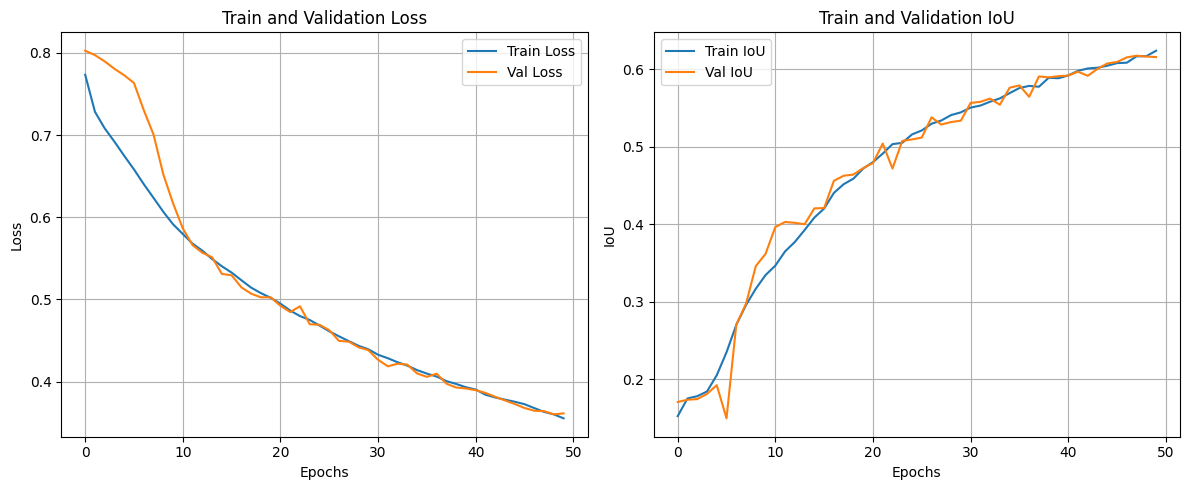

In [43]:
model_unet = R2AttU_Net().to(device) 
metric = BinaryJaccardIndex(threshold=0.5).to(device)
criterion = DiceLoss()
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=1e-4, weight_decay=1e-5)
# model_unet = model_unet.to(device)

train_model(model_unet, criterion, optimizer, metric, train_loader, val_loader, epochs=50, device=device, logger=logger)

In [ ]:
def inference(model, data_loader, metric_computer, device):
    """Выполняет инференс и оценку модели"""
    predicted_masks = []
    model.eval()
    
    # перед использованием сбрасываем состояние метрики с прошлых запусков
    metric_computer.reset()
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Inference"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # Обновляем состояние метрики
            metric_computer.update(outputs, labels)
            
            # Сохраняем маски для визуализации
            preds_proba = torch.sigmoid(outputs)
            preds_binary = (preds_proba > 0.5).float()
            predicted_masks.append(preds_binary.cpu())
            
    final_metric_value = metric_computer.compute()
    
    all_predicted_masks = torch.cat(predicted_masks, dim=0)
    
    return final_metric_value.item(), all_predicted_masks

In [45]:
test_metric, pred_masks = inference(model_unet, val_loader, metric, device)
print(test_metric)

Inference: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

0.6158364415168762


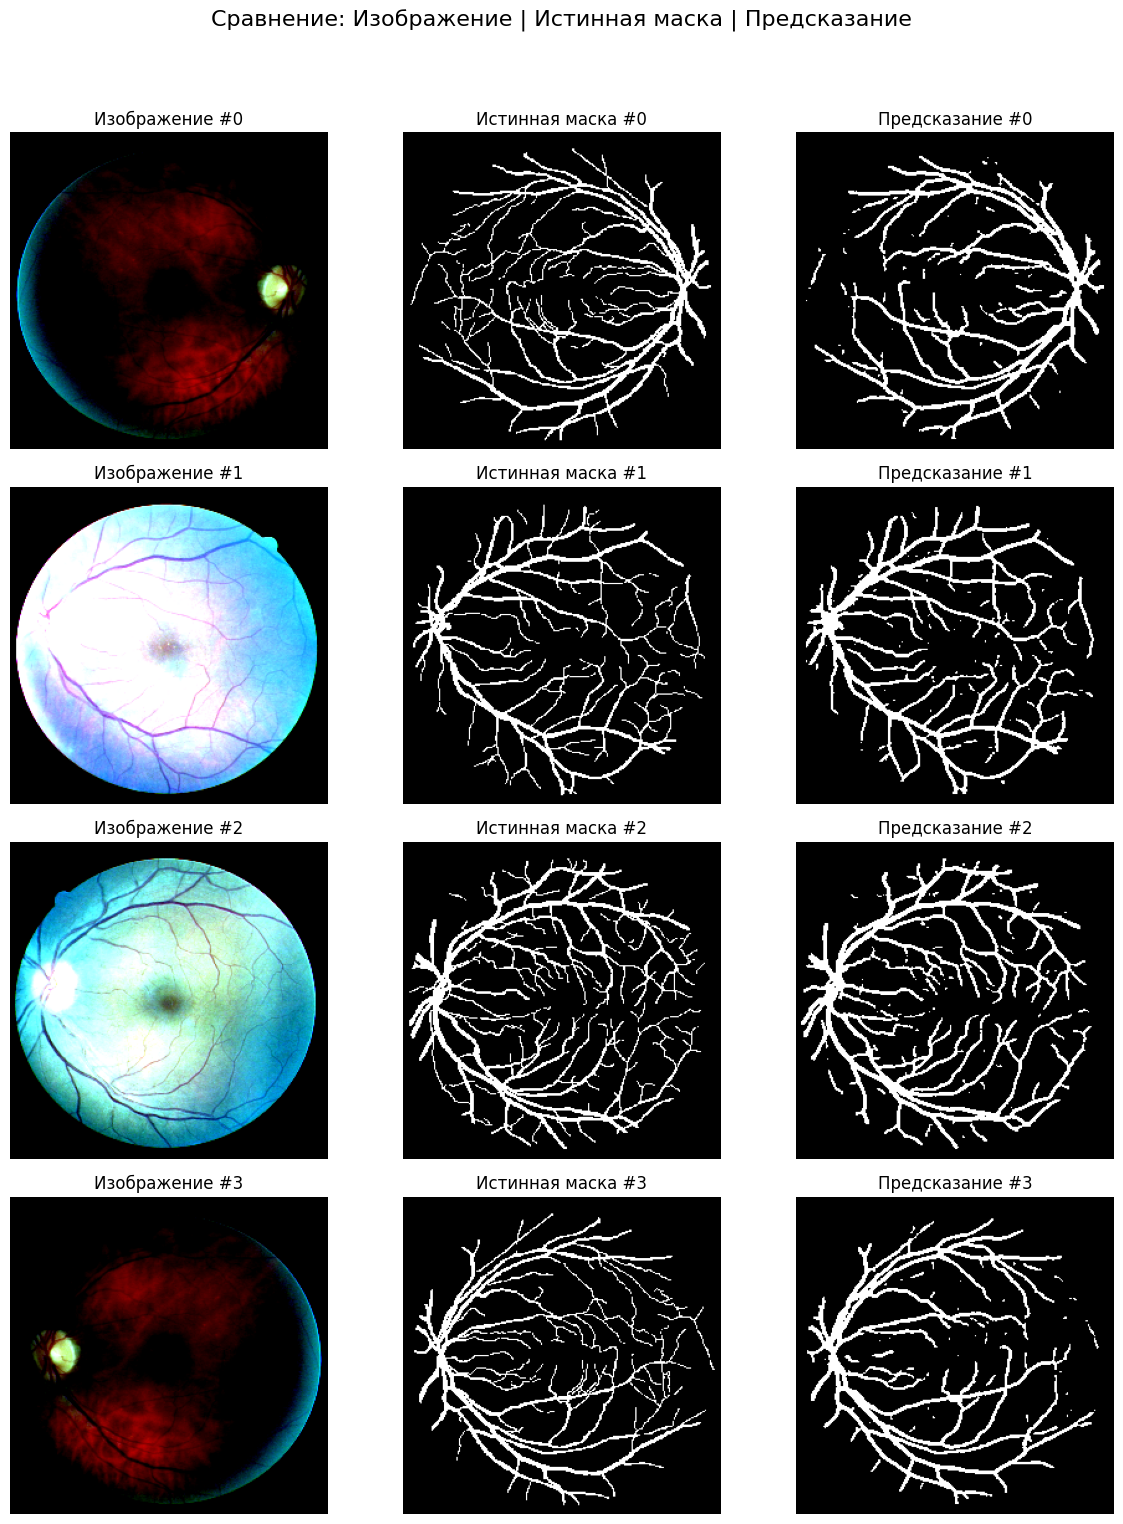

In [ ]:
inputs_batch, labels_batch = next(iter(val_loader))

inputs_batch_device = inputs_batch.to(device)
model_unet.eval()
with torch.no_grad():
    outputs_batch = model_unet(inputs_batch_device)

preds_proba = torch.sigmoid(outputs_batch)
preds_binary = (preds_proba > 0.5).float().cpu()

num_examples = 4
fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))
fig.suptitle("Сравнение: Изображение | Истинная маска | Предсказание", fontsize=16)

for i in range(num_examples):
    axes[i, 0].imshow(inputs_batch[i].permute(1, 2, 0))
    axes[i, 0].set_title(f"Изображение #{i}")
    axes[i, 0].axis('off')
    
    # Истинная маска
    axes[i, 1].imshow(labels_batch[i].squeeze(), cmap='gray')
    axes[i, 1].set_title(f"Истинная маска #{i}")
    axes[i, 1].axis('off')
    
    # Предсказанная маска
    axes[i, 2].imshow(preds_binary[i].squeeze(), cmap='gray')
    axes[i, 2].set_title(f"Предсказание #{i}")
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [47]:
task.close()